# Initial analysis of univariate time series data

Differencing is not a way to isolate trend and seasonality, it can only be used to *remove* trend and seasonality

In [70]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import and describe data

For this exercise, we use the data described below, available from the [SACAC](https://sacac.org.za/resources/) website:

https://sacac.org.za/wp-content/uploads/2023/07/sensor-F-oilgas-thornhill-2007.csv

| Attribute            | Value                                   |
|----------------------|-----------------------------------------|
| Type of measurement  | Flow                                    |
| Industry             | Oil & Gas                               |
| Data length          | 1500                                    |
| Sampling rate        | 20 second                               |
| Company              | Anonymous                               |
| Normalised           | Yes                                     |
| Contributor          | Nina F. Thornhill, Imperial College London |
| Year of origin       | 2007                                    |

First appearance in publication: Thornhill, N.F., 2007, Locating the source of a disturbance, In Process Control Performance Assessment; From Theory to Implementation, Chapter 6, Eds: D.O. Uduehi, A. Ordys and M.A. Johnson, Springer-Verlag (London) Ltd, ISBN 1846286239.

Description: It is known that the there was a faulty steam sensor in the steam flow loop FC1. It was an orifice plate flow meter but there was no weep-hole in the plate which had the effect that condensate collected on the upstream side until it reached a critical level, and the accumulated liquid would then periodically clear itself by siphoning through the orifice. The challenge for the analysis of this unit is to verify that the faulty steam flow loop is the root cause of the disturbance.    

In [ ]:
# Read dataset into a dataframe, ensuring datetime index. Describe the main statistics
df = pd.read_csv('https://sacac.org.za/wp-content/uploads/2023/07/sensor-F-oilgas-thornhill-2007.csv',
                 delimiter=';',
                 index_col='Time')


# <---- Insert code here to show descriptive statistics of the dataset


,PV,SP,OP,Error
count,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03
mean,-8.673333e-09,2.778216e-08,1.287600e-07,3.113333e-08
std,9.999993e-01,1.000000e+00,9.999994e-01,9.999994e-01
min,-2.759300e+00,-2.439100e+00,-2.781800e+00,-2.660300e+00
25%,-6.266125e-01,-8.124000e-01,-6.908025e-01,-7.466900e-01
50%,1.990550e-02,2.838200e-01,1.372550e-01,-7.461550e-02
75%,8.529300e-01,8.529950e-01,8.060100e-01,7.123475e-01
max,2.132000e+00,1.537400e+00,1.977100e+00,2.552200e+00


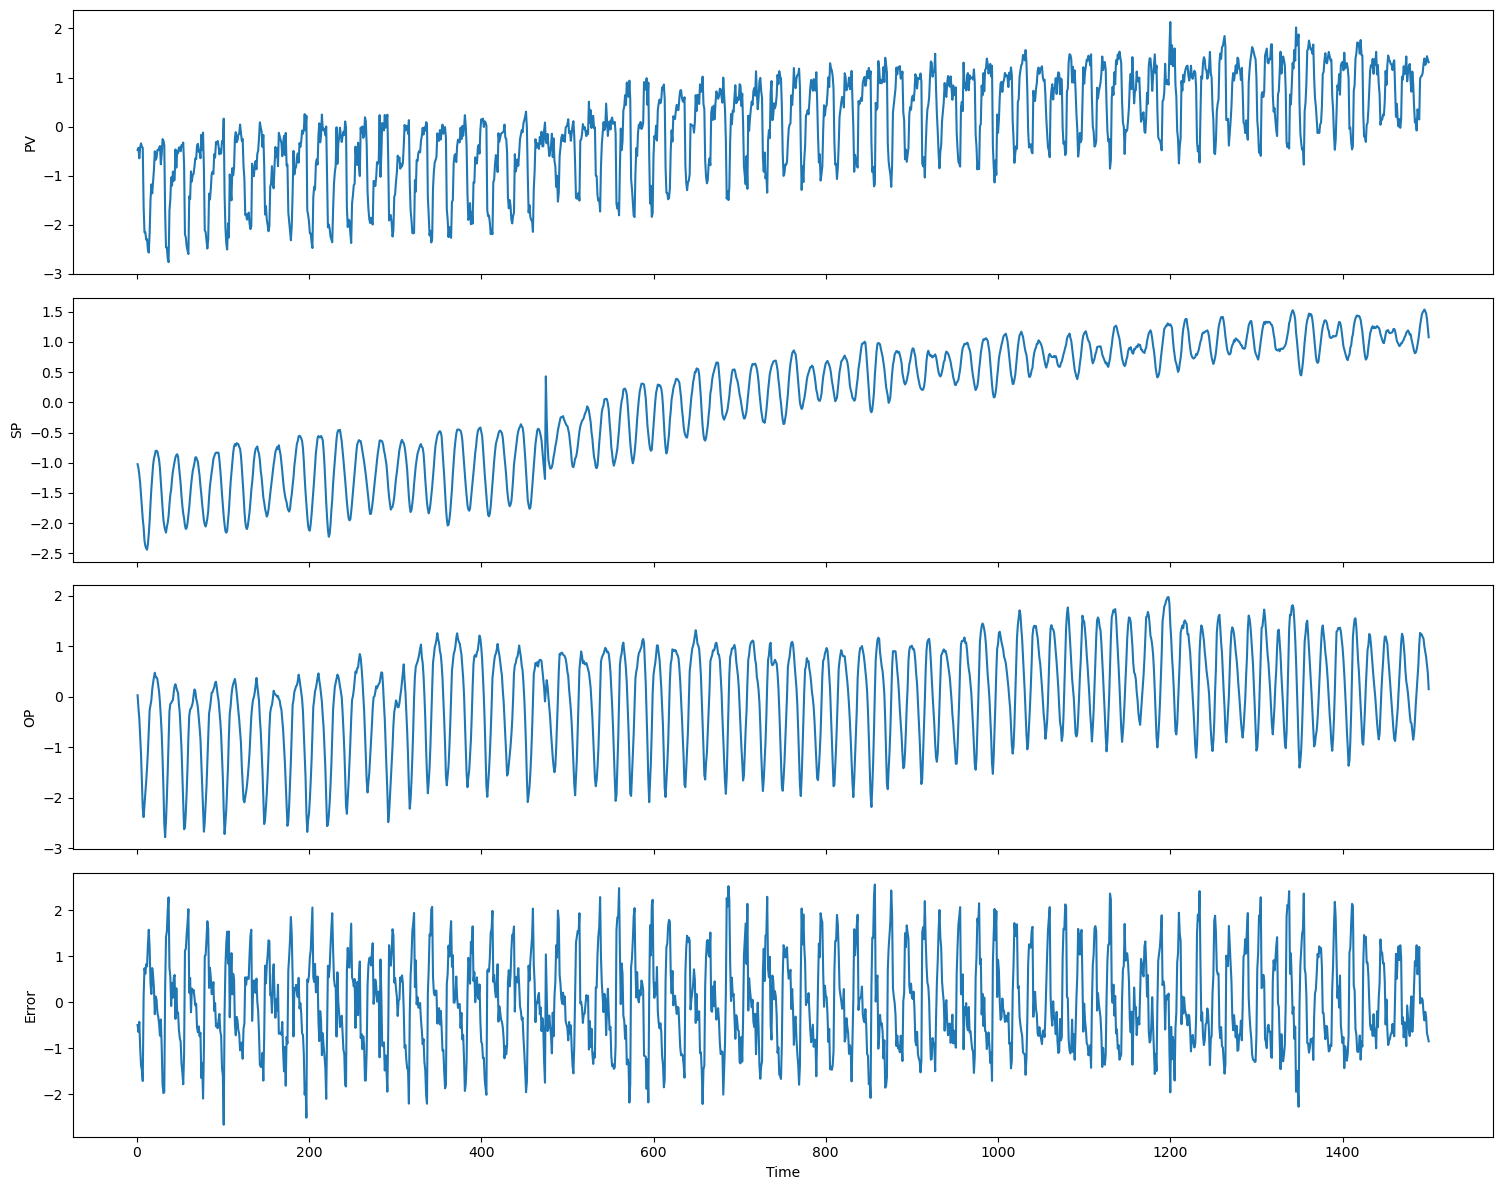

In [72]:
# Plot all time series in the dataset
fig, axes = plt.subplots(len(df.columns), 1, figsize=(15, 3*len(df.columns)), sharex=True)
for i, col in enumerate(df.columns):
    df[col].plot(ax = axes[i], ylabel=col)
plt.tight_layout()

Select `PV` as the time series variable to analysis

In [73]:
ts = df['PV'].dropna()

## Visually assessing stationarity
A stationary time series has a constant mean and variance. By plotting the rolling mean and standard deviation, we obtain a sense of the stationarity of the series. We can use the pandas method `df.rolling` to plot rolling statistics. 

Any method that can normally be applied to a pandas dataframe (e.g., `df.mean`) can be applied to rolling windows of the dataframe using the rolling method. 

See https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.rolling.html

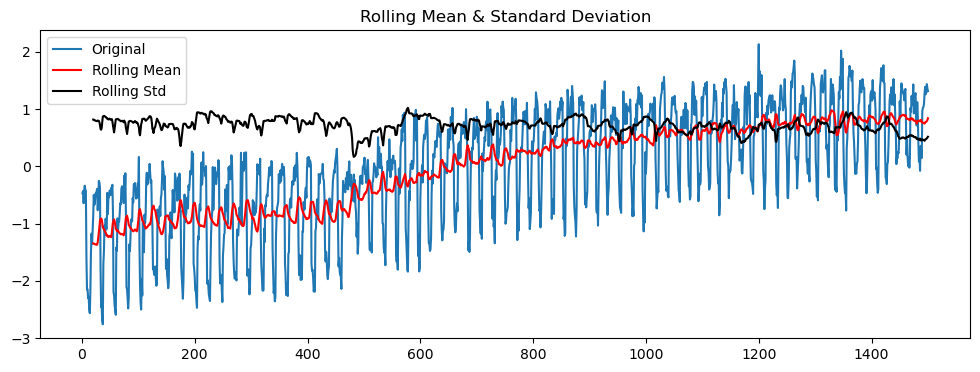

In [ ]:
# Set window size for rolling statistics
window_size = 20

# Plot rolling statistics
plt.figure(figsize=(12, 4))
plt.plot(ts, label='Original')
plt.plot(ts.rolling(window_size).mean(), label='Rolling Mean', color='red')

# The rolling standard deviation gives an indication of stationarity
# <---- Insert code here to plot the rolling standard deviation

plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

🔍 The rolling mean is essentially a smoothing filter. What are the filter weights? Can they be adjusted? See the pandas API reference for help.

## Time series decomposition
A time series can be decomposed into trend, seasonality, and random fluctuations. This is usually done using a smoothing filter. The `statsmodels` library performs time series decomposition using this approach.

See the [statsmodels API](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose). 

Experiment with different periods. You can use `df.head(N)` to show the first `N` entries in the dataframe, which may help you estimate the period.

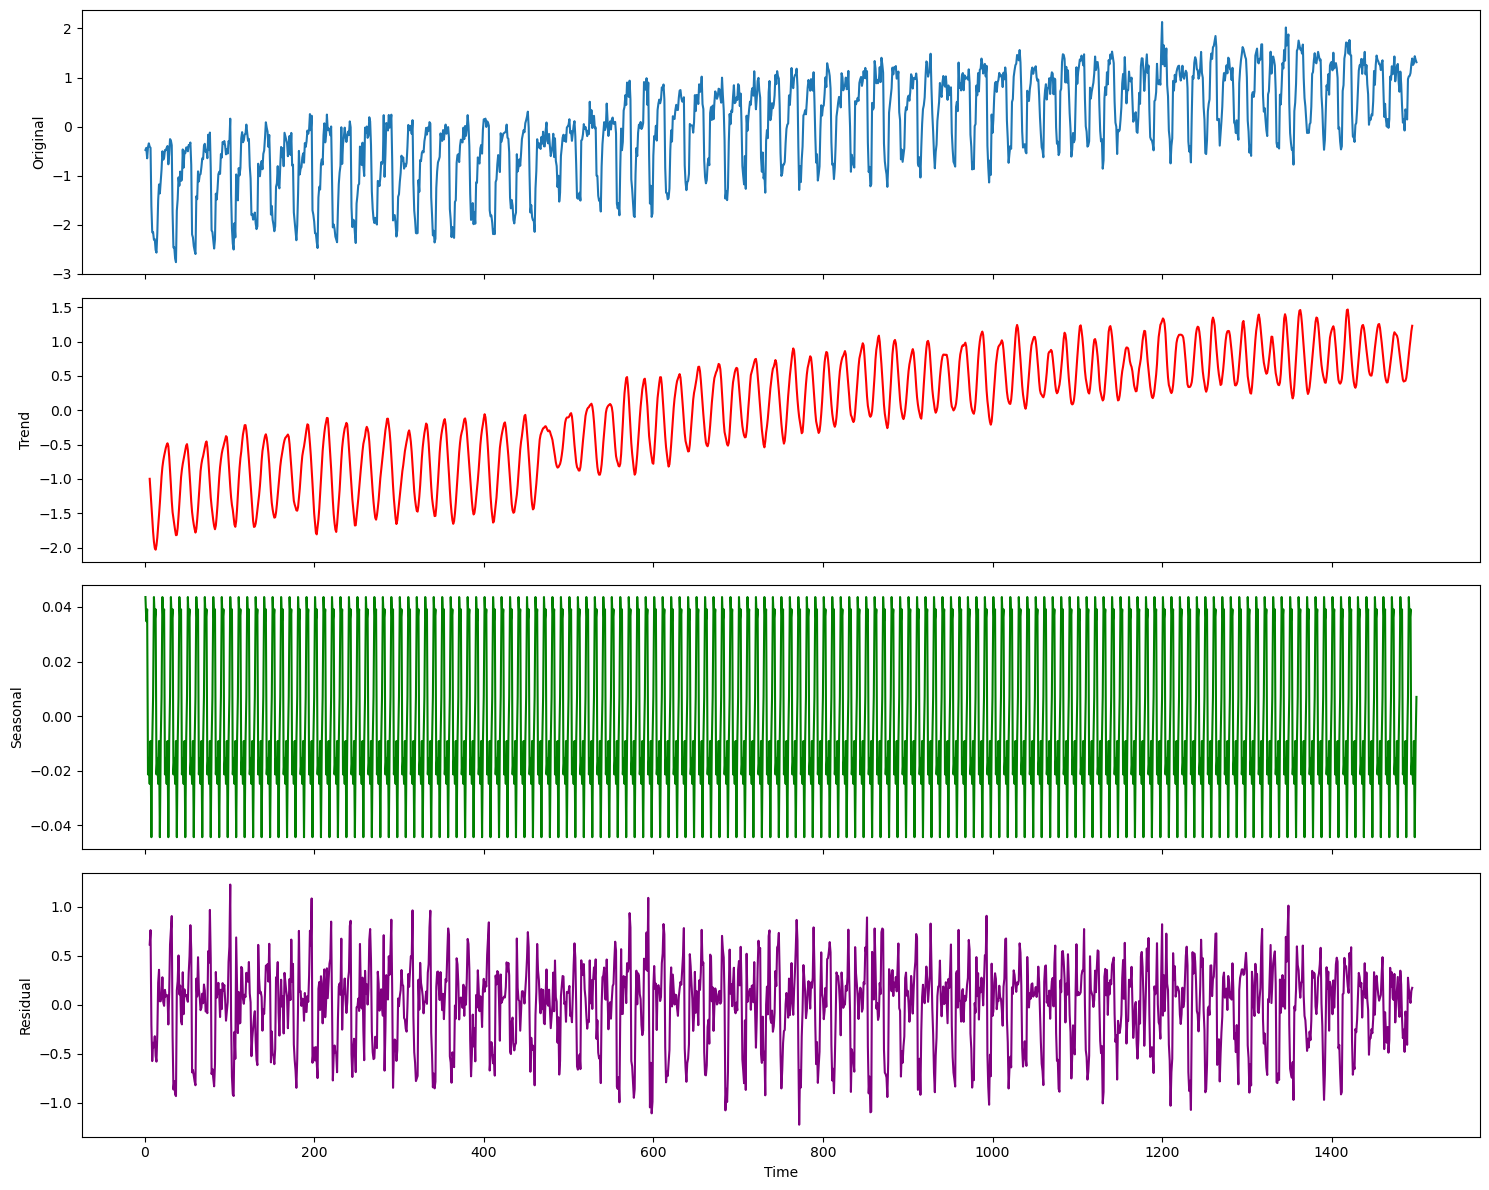

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
period = 10
decomposition = seasonal_decompose(ts, model='additive', period=period)

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Original series
decomposition.observed.plot(ax=axes[0])
axes[0].set_ylabel('Original')

# Trend component
decomposition.trend.plot(ax=axes[1], color='red')
axes[1].set_ylabel('Trend')

# Seasonal component
decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')

# Residual/Noise component
# <---- Insert code here to plot the residual component

plt.tight_layout()

The sample autocorrelation (ACF) is a useful way to gauge whether trend and seasonality has been removed. Plot the ACF for the original series as well as the residual component. 

🔍 Can the ACF be used to inform the period?

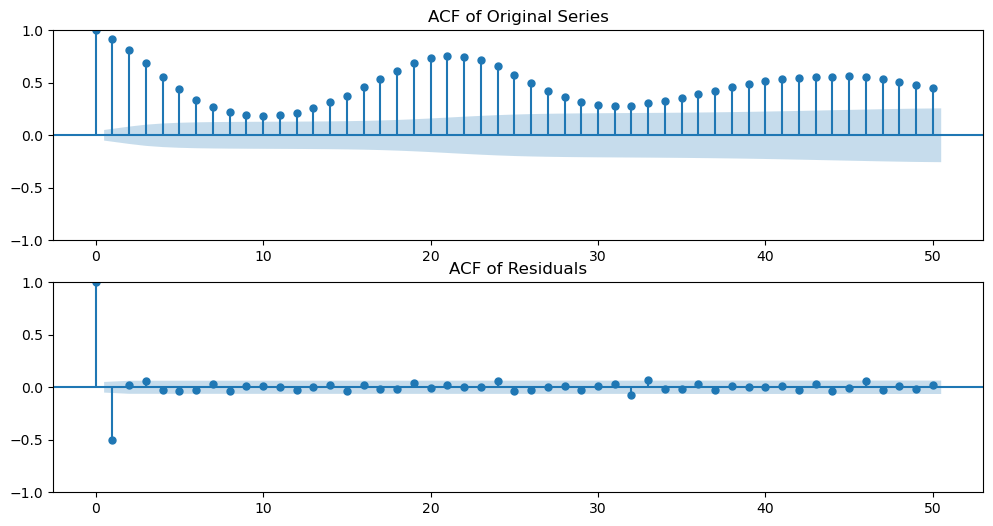

In [76]:
from statsmodels.graphics.tsaplots import plot_acf

# Perform decomposition
period = 2
decomposition = seasonal_decompose(ts, model='additive', period=period)


# Plot ACF
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(ts, lags=50, ax=ax[0], title='ACF of Original Series')
plot_acf(decomposition.resid.dropna(), lags=50, ax=ax[1], title='ACF of Residuals')
plt.show()

## Differencing
A key step in subsequent analysis will be time-series differencing. The pandas method `df.diff(N)` is useful here. Use `N = 1` for standard differencing and `N > 1` for "seasonal" differencing, as described in Chatfield.

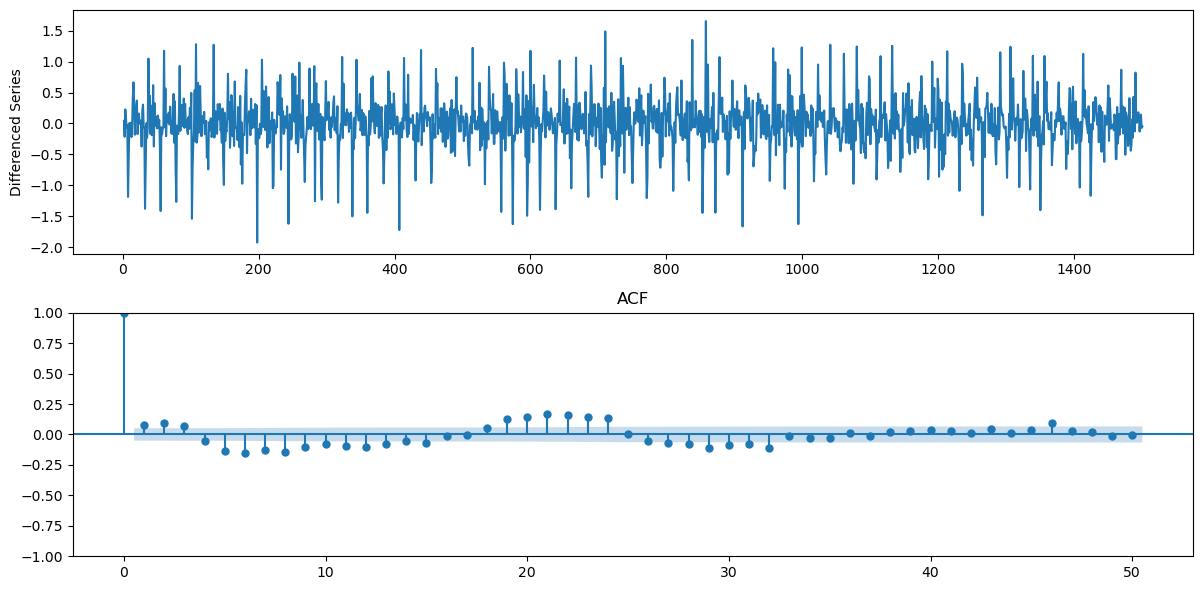

In [ ]:
ts_diff = ts.diff().dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(ts_diff, label='Differenced Series')
axes[0].set_ylabel('Differenced Series')
# <---- Add code to plot the ACF of the differenced series

plt.tight_layout()


🔍 You can perform seasonal differencing using:

`ts_seasonal_diff = ts.diff(periods=period).dropna()`

Use the ACF plot to determine whether seasonal differencing is appropriate.

*Hint: look for spurious autocorrelations that may result from the seasonal differencing*

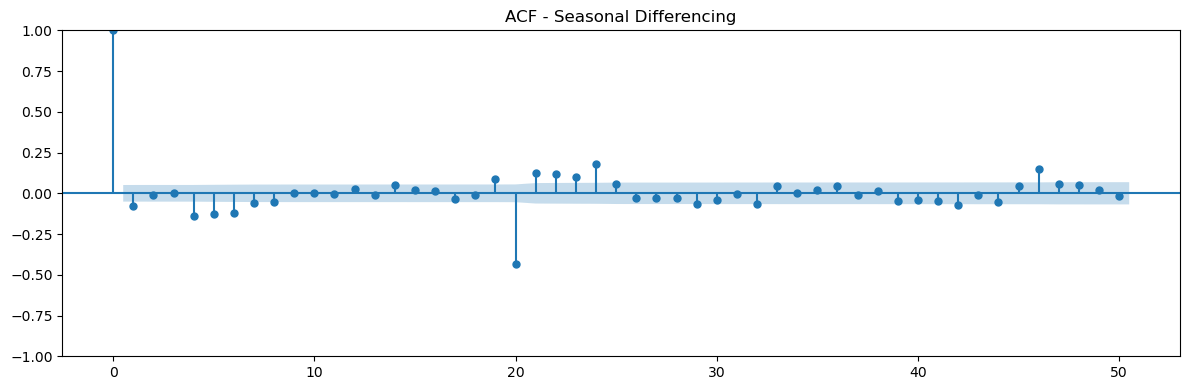

In [ ]:
# <----- Investigate seasonal differencing


🔍 We may try to find the trend $y_t$ by subtracting the differenced series $w_t$ from the original time series $x_t$, i.e.,

$ w_t = x_t - x_{t-1} $

$ y_t = x_t - w_t $

Show that $y_t$ does not give the trend, but simply the lagged variable $x_{t-1}$